In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.mlab
import scipy.io.wavfile
import scipy
import pandas as pd
import time
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
dataset = pd.read_csv('/home/husein/space/UrbanSound8K/metadata/UrbanSound8K.csv')
dataset.slice_file_name = 'audio/fold' + dataset.fold.astype(str) + '/' + dataset.slice_file_name
dataset = dataset.iloc[np.random.permutation(len(dataset))]
dataset.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
3260,audio/fold10/167464-0-0-24.wav,167464,12.000000,16.000000,2,10,0,air_conditioner
6893,audio/fold1/57553-3-2-0.wav,57553,13.063603,14.279479,2,1,3,dog_bark
8649,audio/fold3/98681-9-0-0.wav,98681,0.000000,4.000000,2,3,9,street_music
2201,audio/fold9/155044-9-0-38.wav,155044,19.000000,23.000000,1,9,9,street_music
4269,audio/fold8/180134-4-2-15.wav,180134,49.378110,53.378110,1,8,4,drilling


In [3]:
unique_sound = np.unique(dataset.iloc[:, -1])
unique_sound

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music'], dtype=object)

In [4]:
# define our global variables
learning_rate = 0.001
sound_dimension = [64, 512]
batch_size = 128
epoch = 20

In [5]:
def processAudio(audio_file):
    rate, data = scipy.io.wavfile.read(audio_file)
    try:
        if data.shape[1]:
            data = np.mean(data, axis = 1)
    except:
        pass
    audio = matplotlib.mlab.specgram(data)[0]
    audio = scipy.misc.imresize(audio, sound_dimension)
    return audio.flatten()

In [6]:
class Model:
    def __init__(self, size_output):
        self.X = tf.placeholder(tf.float32, (None, sound_dimension[0] * sound_dimension[1]))
        self.Y = tf.placeholder(tf.float32, (None, size_output))
        
        w1 = tf.Variable(tf.random_normal([sound_dimension[0] * sound_dimension[1], 784], stddev = np.sqrt(1/784.0)))
        b1 = tf.Variable(tf.random_normal([784], stddev = 0))
        
        w2 = tf.Variable(tf.random_normal([784, 256], stddev = np.sqrt(1/256.0)))
        b2 = tf.Variable(tf.random_normal([256], stddev = 0))
        
        w3 = tf.Variable(tf.random_normal([256, 100], stddev = np.sqrt(1/100.0)))
        b3 = tf.Variable(tf.random_normal([100], stddev = 0))
        
        w4 = tf.Variable(tf.random_normal([100, size_output], stddev = np.sqrt(1/(size_output * 1.0))))
        b4 = tf.Variable(tf.random_normal([size_output], stddev = 0))
        
        hidden1 = tf.nn.relu(tf.matmul(self.X, w1) + b1)
        hidden2 = tf.nn.relu(tf.matmul(hidden1, w2) + b2)
        hidden3 = tf.nn.relu(tf.matmul(hidden2, w3) + b3)
        self.logits = tf.matmul(hidden3, w4) + b4
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.Y))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [7]:
no_classes = np.unique(dataset['classID']).shape[0]
sess = tf.InteractiveSession()
model = Model(no_classes)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())

train_dataset = dataset.iloc[:int(dataset.shape[0] * 0.80), :]
test_dataset = dataset.iloc[int(dataset.shape[0] * 0.80):, :]

In [8]:
ACCURACY, LOST = [], []
for i in range(epoch):
    last = time.time()
    total_acc, total_loss = 0, 0
    for k in range(0, (train_dataset.shape[0] // batch_size) * batch_size, batch_size):
        batch_x, batch_y = [], []
        for n in range(batch_size):
            try:
                batch_x.append(processAudio(train_dataset.slice_file_name.iloc[k + n]))
                onehot = np.zeros((no_classes))
                onehot[train_dataset.classID.iloc[k + n]] = 1.0
                batch_y.append(onehot)
            except Exception as e:
                continue
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        loss, _ = sess.run([model.cost, model.optimizer], feed_dict = {model.X: batch_x, model.Y: batch_y})
        total_acc += sess.run(model.accuracy, feed_dict = {model.X: batch_x, model.Y: batch_y})
        total_loss += loss
    total_loss /= (train_dataset.shape[0] // batch_size)
    total_acc /= (train_dataset.shape[0] // batch_size)
    ACCURACY.append(total_acc)
    LOST.append(total_loss)
    print('epoch: ', i + 1, 'avg loss: ', total_loss, 'avg acc: ', total_acc, 'avg time: ', (time.time() - last) / (train_dataset.shape[0] // batch_size))

('epoch: ', 1, 'avg loss: ', 38.681511048917415, 'avg acc: ', 0.34631681497450229, 'avg time: ', 1.1846145391464233)
('epoch: ', 2, 'avg loss: ', 10.284185537585506, 'avg acc: ', 0.46804722039787855, 'avg time: ', 1.1832178124675043)
('epoch: ', 3, 'avg loss: ', 4.818431311183506, 'avg acc: ', 0.58318529691961074, 'avg time: ', 1.1827876479537398)
('epoch: ', 4, 'avg loss: ', 3.856180195455198, 'avg acc: ', 0.63080330910506077, 'avg time: ', 1.1820432036011308)
('epoch: ', 5, 'avg loss: ', 3.2105771016191551, 'avg acc: ', 0.67482221457693314, 'avg time: ', 1.1815304623709784)
('epoch: ', 6, 'avg loss: ', 2.2258183338023998, 'avg acc: ', 0.71529215795022472, 'avg time: ', 1.1794133892765752)
('epoch: ', 7, 'avg loss: ', 2.0526084447348558, 'avg acc: ', 0.75042694807052612, 'avg time: ', 1.178878316172847)
('epoch: ', 8, 'avg loss: ', 1.5949348023644201, 'avg acc: ', 0.77596086815551479, 'avg time: ', 1.1801795738714713)
('epoch: ', 9, 'avg loss: ', 1.196668208197311, 'avg acc: ', 0.8146

In [9]:
batch_x, batch_y, labels = [], [], []
for n in range(test_dataset.shape[0]):
    try:
        batch_x.append(processAudio(test_dataset.slice_file_name.iloc[n]))
        onehot = np.zeros((no_classes))
        onehot[test_dataset.classID.iloc[n]] = 1.0
        batch_y.append(onehot)
        labels.append(test_dataset.classID.iloc[n])
    except Exception as e:
        continue
batch_x = np.array(batch_x)
batch_y = np.array(batch_y)
acc, logits = sess.run([model.accuracy, tf.cast(tf.argmax(model.logits, 1), tf.int32)], feed_dict = {model.X : batch_x, model.Y : batch_y})
print 'testing accuracy: ' + str(acc)
print(metrics.classification_report(labels, logits, target_names = np.unique(unique_sound)))

testing accuracy: 0.472927
                  precision    recall  f1-score   support

 air_conditioner       0.39      0.39      0.39       112
        car_horn       0.40      0.50      0.45        68
children_playing       0.31      0.20      0.24       116
        dog_bark       0.62      0.47      0.54       142
        drilling       0.39      0.83      0.53       142
   engine_idling       0.47      0.50      0.48       127
        gun_shot       0.70      0.55      0.62        67
      jackhammer       0.50      0.52      0.51       137
           siren       0.68      0.68      0.68       132
    street_music       0.32      0.09      0.14       139

     avg / total       0.47      0.47      0.45      1182



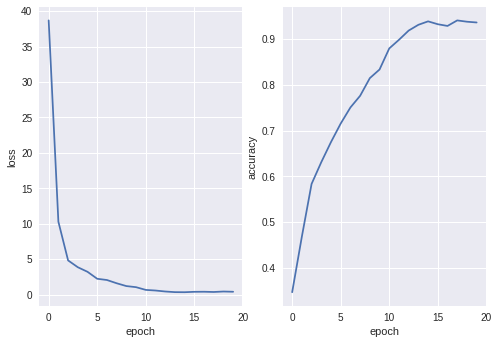

In [10]:
EPOCH = np.arange(len(LOST))
plt.subplot(1, 2, 1)
plt.plot(EPOCH, LOST)
plt.xlabel('epoch'); plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.show()